In [9]:
import numpy as np
from numpy import *
import time
from scipy.misc import imread
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]


im1 = (imread("laska.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)
im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]

im2 = (imread("poodle.png")[:,:,:3]).astype(float32)
im2[:, :, 0], im2[:, :, 2] = im2[:, :, 2], im2[:, :, 0]

/home/jiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/home/jiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [11]:
print (im1.shape)

(227, 227, 3)


In [12]:
x = tf.placeholder(tf.float32, (None,) + xdim)
print (x)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Tensor("Placeholder:0", shape=(?, 227, 227, 3), dtype=float32)


In [13]:
net_data = load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()


def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):

    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)

    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups =  tf.split(input, group, 3)   #tf.split(3, group, input)
        kernel_groups = tf.split(kernel, group, 3)  #tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          #tf.concat(3, output_groups)
    return tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])

In [14]:
#conv1
#conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
conv1 = tf.nn.relu(conv1_in)

#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv2 = tf.nn.relu(conv2_in)


#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#fc6
#fc(4096, name='fc6')
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

#fc7
#fc(4096, name='fc7')
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)

#fc8
#fc(1000, relu=False, name='fc8')
fc8W = tf.Variable(net_data["fc8"][0])
fc8b = tf.Variable(net_data["fc8"][1])
fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)


#prob
#softmax(name='prob'))
prob = tf.nn.softmax(fc8)

init = tf.initialize_all_variables()
sess = tf.Session(config=config)
sess.run(init)

t = time.time()
output = sess.run(prob, feed_dict = {x:[im1,im2]})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [15]:
def getActivations(layer, inp):
    units = sess.run(layer, feed_dict={x: [inp]})
    plotNNFilter(units)

In [16]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 12
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        # plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

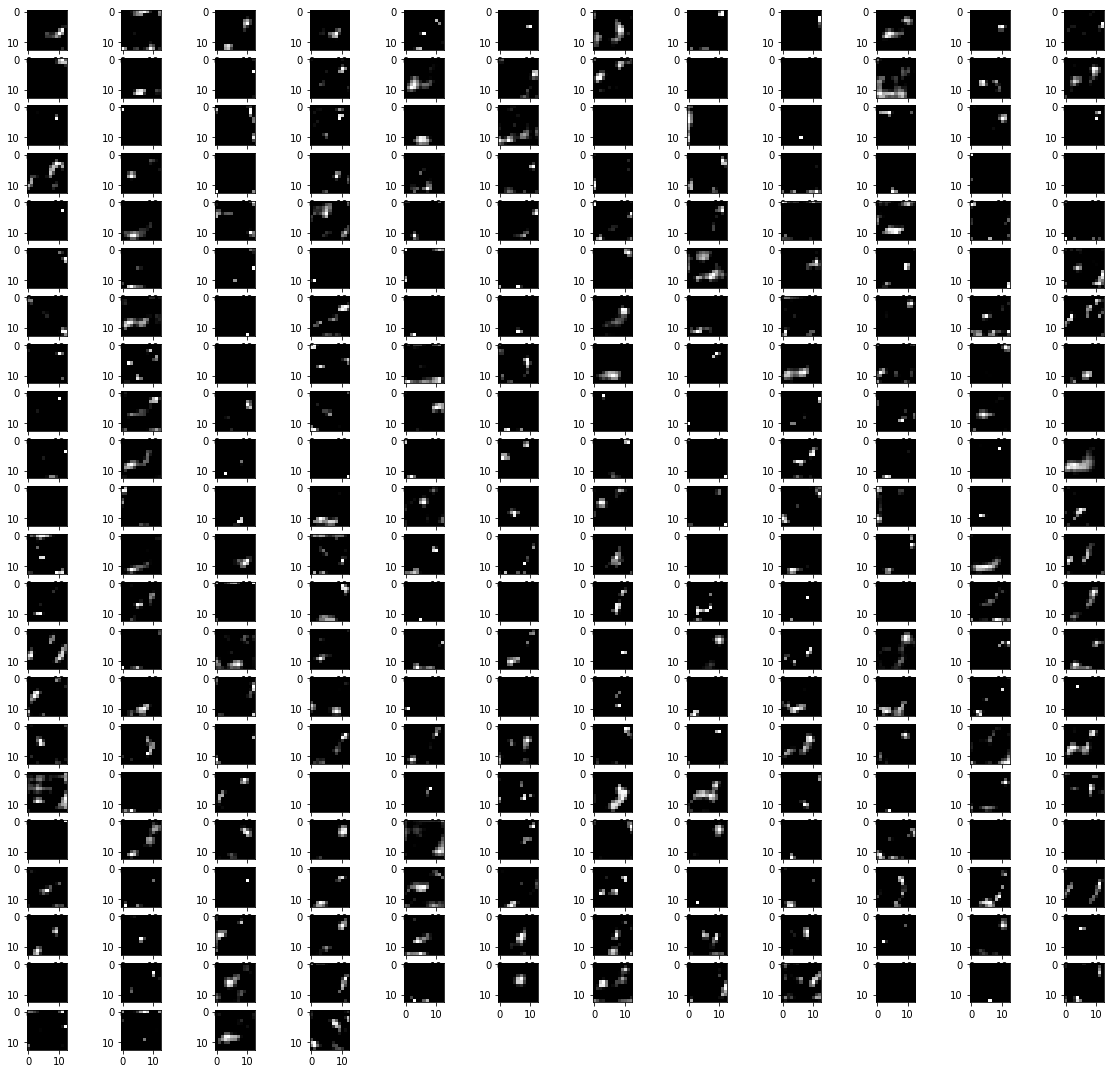

In [17]:
getActivations(conv5, im1)

## K-means

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


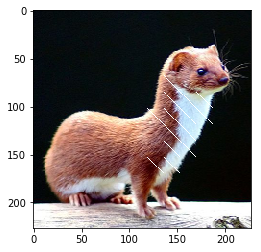

In [18]:
from sklearn.cluster import KMeans
import cv2
import matplotlib.image as mpimg
units = sess.run(conv5, feed_dict={x: [im1]})[0, :, :, :]

filters = []
for i in range(units.shape[2]):
    img = units[:,:,i].astype(np.uint8)
    equ = cv2.equalizeHist(img)
    filters.append(equ)
filters = np.asarray(filters)
filters = filters.reshape(units.shape[2], -1).T       # 169,256


n = 5

kmeans = KMeans(n_clusters=n, random_state=0).fit(filters)

clusters = []

for i in range(n):
    clusters.append([])
    for j in range(filters.shape[0]):
        if i == kmeans.labels_[j]:
            clusters[i].append(j)

cluster_num = 3

idx = np.unravel_index(clusters[cluster_num], units[:,:,0].shape)

img = img=mpimg.imread("laska.png")

scale = int(np.floor(227/units[:,:,0].shape[0]))
for i in range(len(clusters[cluster_num])):
    target = (idx[0][i],idx[1][i])
    for j in range(scale):
        if target[0]*scale+j <= 226 and target[1]*scale+j <= 226:
            img[target[0]*scale+j,target[1]*scale+j,0] = 20
            img[target[0]*scale+j,target[1]*scale+j,1] = 220
            img[target[0]*scale+j,target[1]*scale+j,2] = 20
        
plt.imshow(img)
plt.show()


## Self-Sim

In [37]:
from numpy import linalg as LA

def getMat(filedir):
    
    im1 = (imread(filedir)[:,:,:3]).astype(float32)
    im1 = im1 - mean(im1)
    im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]
    im1 = cv2.resize(im1, (227, 227)) 
    
    Y = []
    
    rep = []

    for i in range(5):

        layer = globals()["conv" + str(i+1)]

        out = sess.run(layer, feed_dict={x: [im1]})[0, :, :, :]

        M = out.shape[2]  # Num of Filiters

        N = out.shape[0]*out.shape[1]  # Num of Pixcels

        X = []

        for i in range(out.shape[2]):
            img = out[:,:,i].astype(np.uint8).reshape(N,-1)
            equ = cv2.equalizeHist(img)
            X.append(equ)

        X = np.asarray(X).reshape((M,N)) # M*N
        
        K = X.dot(X.T)

        K = K/N
                    
        w, v = LA.eigh(K)
        w = w[-30:]
        v = v[-30:]
        
        v = v.T

        log_w = np.diag(np.log(w))
                
        Y.append(v.dot(log_w).dot(v.T).reshape(-1,1)[0:96,:])
        rep.append(v.dot(log_w).dot(v.T).reshape(-1,1)[0:96,:])
        

    Y = np.asanyarray(Y).reshape((5,96))
    rep = np.asanyarray(rep).flatten()

    for i in range (5):
        Y[i][0] = 0

    corr = np.corrcoef(Y)

    l = []
    
    for i in range (5):
        for j in range (5):
            if j > i:
                l.append(corr[i][j])
    l = np.asarray(l)
    
    rep = np.concatenate([rep, l])
        
    return rep
    

In [38]:
print(getMat('dog_sample.jpg').shape)

/home/jiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


(490,)


### feature vectors for diff layers ----> correlation mat -----> compare between images

In [39]:
import os

dog = []
cat = []
f_d = os.listdir('dog')
f_c = os.listdir('cat')

for i in range(500):
    dog.append(getMat('dog/'+f_d[i]))
    cat.append(getMat('cat/'+f_c[i]))
    if i%20 == 0:
        print(i)


/home/jiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


In [40]:
dog = np.asanyarray(dog)
cat = np.asanyarray(cat)
sample = getMat('dog/dog.609.jpg')
def getDist(sample, dog, cat):
    dog_diff = 0
    cat_diff = 0
    for i in range (500):
        dog_diff += np.sqrt(np.sum((dog[i]-sample)**2))
        cat_diff += np.sqrt(np.sum((cat[i]-sample)**2))
    return dog_diff, cat_diff

/home/jiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [41]:
np.save('dog_mat.npy', dog)
np.save('cat_mat.npy', cat)

In [42]:
dog = np.load('dog_mat.npy')
cat = np.load('cat_mat.npy')
print(dog.shape)

(500, 490)


In [43]:
from sklearn import svm
dc = np.concatenate((dog, cat), axis=0)
label = np.zeros((1000))
label[0:500] = 1
clf = svm.SVC()
clf.fit(dc, label) 


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
import random
correct = 0
for i in range(100):
    ind = random.randint(1,12500)
    d = getMat('dog/dog.%s.jpg'%ind)
    c = getMat('cat/cat.%s.jpg'%ind)
    if  clf.predict([d])[0] == 1:
        correct += 1
    if clf.predict([c])[0] == 0:
        correct += 1
print(correct/200)
print(correct)

/home/jiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


0.455
91


con5 five & fc 1 (try both O2P and direct)

perform O2P on weights instead of atcivation maps -> get y, compute difference mat